## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from scipy.stats import linregress, uniform
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

## 2. Load and Inspect Data

### 2.1. Import and Overview

In [3]:
df = pd.read_csv('data/lead_scoring.csv')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
# Describing data
df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


### 2.2. Checking `null` values

Some columns have 'Select' value => determine missing

In [6]:
df.replace('Select', np.nan, inplace=True)

In [7]:
#Column wise null values in train data set 
null_perc = pd.DataFrame(round((df.isnull().sum())*100/df.shape[0],2)).reset_index()
null_perc.columns = ['Column Name', 'Null Values Percentage']
null_value = pd.DataFrame(df.isnull().sum()).reset_index()
null_value.columns = ['Column Name', 'Null Values']
null_lead = pd.merge(null_value, null_perc, on='Column Name')
null_lead.sort_values("Null Values", ascending = False)

,Column Name,Null Values,Null Values Percentage
13,How did you hear about X Education,7250,78.46
28,Lead Profile,6855,74.19
25,Lead Quality,4767,51.59
31,Asymmetrique Profile Index,4218,45.65
30,Asymmetrique Activity Index,4218,45.65
32,Asymmetrique Activity Score,4218,45.65
33,Asymmetrique Profile Score,4218,45.65
29,City,3669,39.71
12,Specialization,3380,36.58
24,Tags,3353,36.29


**Note**: should drop columns with majority of null values:
 Columns with >45% null values:
- `How did you hear about X Education` (78.46%)
- `Lead Profile` (74.19%)
- `Lead Quality` (51.59%)
- `Asymmetrique Profile Index` (45.65%)
- `Asymmetrique Activity Index` (45.65%)
- `Asymmetrique Activity Score` (45.65%)
- `Asymmetrique Profile Score` (45.65%)


### 2.3. Checking Unique ID

In [8]:
print("Total number of duplicate values in Prospect ID column :" , df.duplicated(subset = 'Prospect ID').sum())
print("Total number of duplicate values in Lead Number column :" , df.duplicated(subset = 'Lead Number').sum())

Total number of duplicate values in Prospect ID column : 0
Total number of duplicate values in Lead Number column : 0


**Note**: `Prospect ID` and `Lead Number` are unique indicators => drop

## 3. Data Cleaning


#### 3.1. Remove Unnecessary Columns
Drop the columns that are identified above.

`Lead Quality`, `Tags`, `Asymmetrique`,  etc. are *created by the sales team once they contact the potential lead* => not be available for the model building.


In [9]:
cols_to_drop = ['Prospect ID','Lead Number','How did you hear about X Education','Lead Profile',
                'Lead Quality','Asymmetrique Profile Score','Asymmetrique Activity Score',
               'Asymmetrique Activity Index','Asymmetrique Profile Index', 'Tags']

In [10]:
df.drop(columns=cols_to_drop, inplace=True)
len(df.columns)

27

#### 3.2. Identifying Columns Type 
Split columns to *Categorical* and *Numerical*

In [11]:
categorical_col = df.select_dtypes(exclude =["number"]).columns.values
numerical_col = df.select_dtypes(include =["number"]).columns.values
print("CATEGORICAL FEATURES : \n {} \n\n".format(categorical_col))
print("NUMERICAL FEATURES : \n {} ".format(numerical_col))

CATEGORICAL FEATURES : 
 ['Lead Origin' 'Lead Source' 'Do Not Email' 'Do Not Call' 'Last Activity'
 'Country' 'Specialization' 'What is your current occupation'
 'What matters most to you in choosing a course' 'Search' 'Magazine'
 'Newspaper Article' 'X Education Forums' 'Newspaper'
 'Digital Advertisement' 'Through Recommendations'
 'Receive More Updates About Our Courses'
 'Update me on Supply Chain Content' 'Get updates on DM Content' 'City'
 'I agree to pay the amount through cheque'
 'A free copy of Mastering The Interview' 'Last Notable Activity'] 


NUMERICAL FEATURES : 
 ['Converted' 'TotalVisits' 'Total Time Spent on Website'
 'Page Views Per Visit'] 


In [12]:
# Get binary categorical columns
binary_cat_cols = [col for col in categorical_col if df[col].nunique() == 2]
print("BINARY CATEGORICAL FEATURES : \n {} ".format(binary_cat_cols))

BINARY CATEGORICAL FEATURES : 
 ['Do Not Email', 'Do Not Call', 'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'A free copy of Mastering The Interview'] 


#### 3.3. Handle Categorical Missing Values

##### Utils

In [13]:
# Checking unique values and null values for the categorical columns
def cat_info(df, categorical_column):
    df_result = pd.DataFrame(columns=["columns","values","unique_values","null_values","null_percent"])
    
    for value in categorical_column:
        df_temp = pd.DataFrame({
            "columns": [value],
            "values": [df[value].unique()],
            "unique_values": [df[value].nunique()],
            "null_values": [df[value].isna().sum()],
            "null_percent": [(df[value].isna().sum()/len(df)*100).round(1)]
        })
        df_result = pd.concat([df_result, df_temp], ignore_index=True)
    
    df_result.sort_values("null_values", ascending=False, inplace=True)
    df_result.set_index("columns", inplace=True)
    return df_result


##### Analysis

In [14]:
df_cat = cat_info(df, categorical_col)
df_cat

/tmp/ipykernel_619039/1865801373.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, df_temp], ignore_index=True)


,values,unique_values,null_values,null_percent
columns,,,,
City,"[nan, Mumbai, Thane & Outskirts, Other Metro C...",6,3669,39.7
Specialization,"[nan, Business Administration, Media and Adver...",18,3380,36.6
What matters most to you in choosing a course,"[Better Career Prospects, nan, Flexibility & C...",3,2709,29.3
What is your current occupation,"[Unemployed, Student, nan, Working Professiona...",6,2690,29.1
Country,"[nan, India, Russia, Kuwait, Oman, United Arab...",38,2461,26.6
Last Activity,"[Page Visited on Website, Email Opened, Unreac...",17,103,1.1
Lead Source,"[Olark Chat, Organic Search, Direct Traffic, G...",21,36,0.4
Lead Origin,"[API, Landing Page Submission, Lead Add Form, ...",5,0,0.0
Through Recommendations,"[No, Yes]",2,0,0.0


##### 3.3.1. Dropping single category columns
**Note**: Some columns only have one category => *Drop as adding no values to the models*


In [15]:
cat_cols_to_drop = df_cat[df_cat['unique_values']==1].index.values.tolist() 
cat_cols_to_drop

['I agree to pay the amount through cheque',
 'Get updates on DM Content',
 'Update me on Supply Chain Content',
 'Receive More Updates About Our Courses',
 'Magazine']

In [16]:
# Dropping columns
df.drop(columns=cat_cols_to_drop, inplace=True)

In [17]:
# Expand the drop columns
cols_to_drop = cols_to_drop + cat_cols_to_drop

# The remaining cat columns
categorical_col = [col for col in categorical_col if col not in cat_cols_to_drop]

In [18]:
# reexamine the categorical columns
df_cat = cat_info(df, categorical_col)
df_cat

/tmp/ipykernel_619039/1865801373.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, df_temp], ignore_index=True)


,values,unique_values,null_values,null_percent
columns,,,,
City,"[nan, Mumbai, Thane & Outskirts, Other Metro C...",6,3669,39.7
Specialization,"[nan, Business Administration, Media and Adver...",18,3380,36.6
What matters most to you in choosing a course,"[Better Career Prospects, nan, Flexibility & C...",3,2709,29.3
What is your current occupation,"[Unemployed, Student, nan, Working Professiona...",6,2690,29.1
Country,"[nan, India, Russia, Kuwait, Oman, United Arab...",38,2461,26.6
Last Activity,"[Page Visited on Website, Email Opened, Unreac...",17,103,1.1
Lead Source,"[Olark Chat, Organic Search, Direct Traffic, G...",21,36,0.4
Lead Origin,"[API, Landing Page Submission, Lead Add Form, ...",5,0,0.0
Newspaper,"[No, Yes]",2,0,0.0


##### 3.3.2. Other Categorical Columns

**Note**: Missing values can be considered as 'Unknown'

`Lead Source`

In [19]:
df['Lead Source'].value_counts()

Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Live Chat               2
Social Media            2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 1
NC_EDM                  1
Name: count, dtype: int64

**Note**: Missing values are minors => Impute with the most occurence 'Google'

In [20]:
df['Lead Source'] = df['Lead Source'].fillna('Google')

`Last Activity`

In [21]:
df['Last Activity'].value_counts()

Last Activity
Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: count, dtype: int64

**Note**: Missing values are minors => Impute with the most occurence 'Email Opened'

In [22]:
df['Last Activity'] = df['Last Activity'].fillna('Email Opened')

`Country`

In [23]:
df['Country'].value_counts()

Country
India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Nigeria                    4
Germany                    4
Canada                     4
Sweden                     3
Italy                      2
Belgium                    2
Ghana                      2
Philippines                2
Netherlands                2
China                      2
Asia/Pacific Region        2
Bangladesh                 2
Uganda                     2
Russia                     1
Sri Lanka                  1
Tanzania                   1
Kenya                      1
Malaysia                   1
Liberia                    1
Denmar

**Note**: 
- Mostly in India 
=> droppable with the fact that it also has many 'Select' Value

In [24]:
df.drop(columns=['Country'], inplace=True)

 `City`

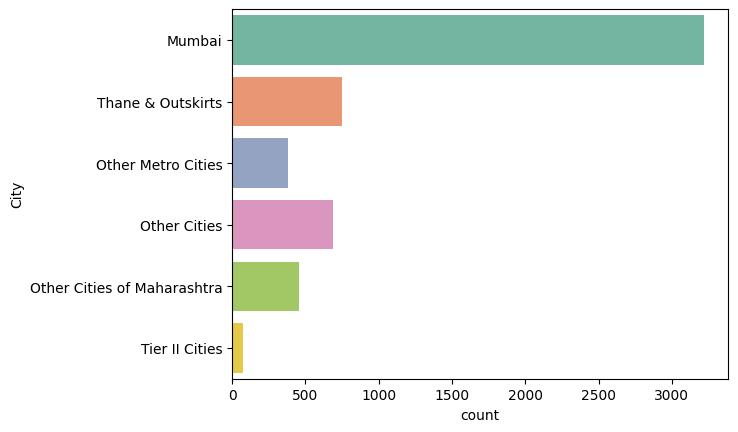

In [25]:
ax = sns.countplot(df, y = 'City', hue = 'City', legend=False, palette = 'Set2')
plt.show()

**Note**: 
- The data is *heavily skewed* => can not impute 'Select' (missing) with any 
=> droppable due to the fact that this is online service and most of the clients are from India


In [26]:
df.drop(columns=['City'], inplace=True)

In [27]:
#### add to cols_to_drop
cols_to_drop = cols_to_drop + ['City', 'Country']

 `Specialization`

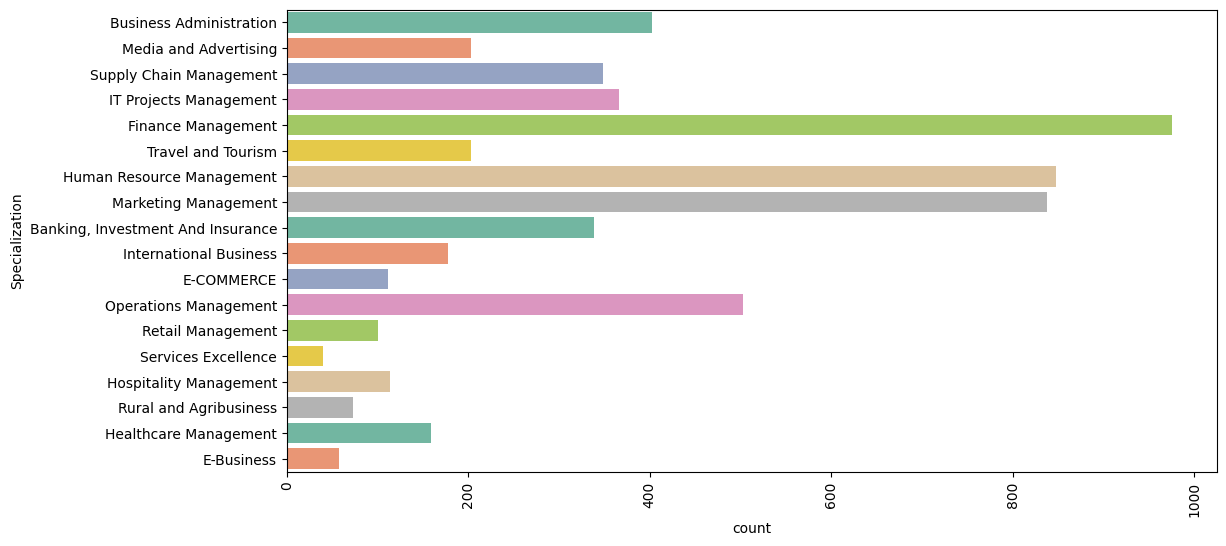

In [28]:
plt.figure(figsize=(12,6))
ax = sns.countplot(df, y = 'Specialization', hue = 'Specialization', legend=False, palette = 'Set2')
plt.xticks(rotation = 90)
plt.show()

**Note**: 'Select' as missing value might be considered as 'Unknown' 


In [29]:
df['Specialization'] = df['Specialization'].fillna('Unknown')

`Occupation`

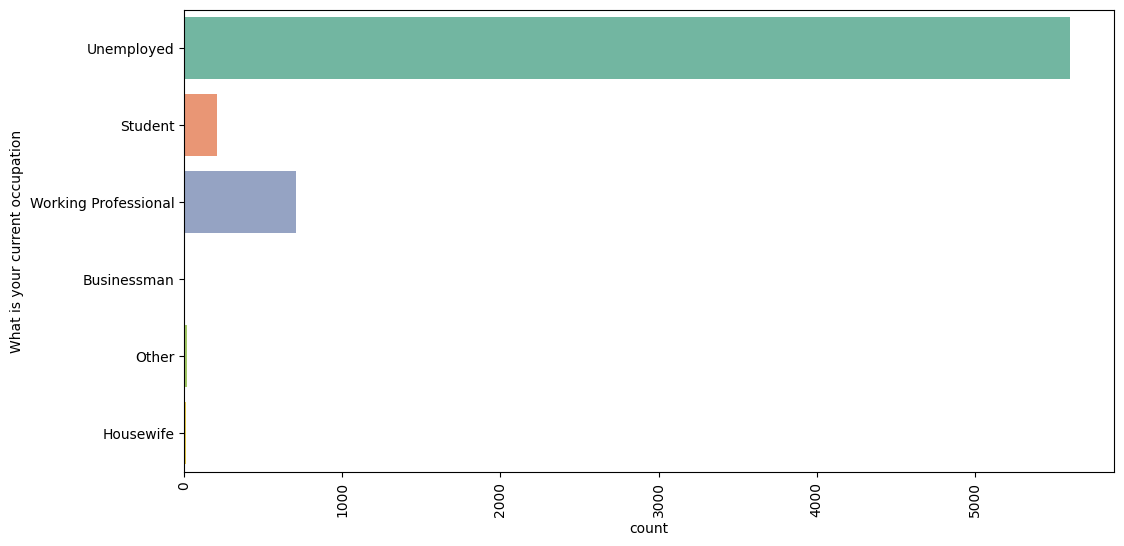

In [30]:
plt.figure(figsize=(12,6))
ax = sns.countplot(df, y = 'What is your current occupation', hue = 'What is your current occupation', legend=False, palette = 'Set2')
plt.xticks(rotation = 90)
plt.show()

**Note**: 'Select' as missing value might be considered as 'Unknown' 


In [31]:
df['What is your current occupation'] = df['What is your current occupation'].fillna('Unknown')

 `What matters most to you in choosing a course`

In [32]:
df['What matters most to you in choosing a course'].value_counts()

What matters most to you in choosing a course
Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

**Note**: Heavily skewed =>> dropable

In [33]:
df.drop(columns=['What matters most to you in choosing a course'], inplace=True)

In [34]:
cols_to_drop = cols_to_drop + ['What matters most to you in choosing a course']

#### 3.4. Handle Numerical Missing Values
No insights just yet => consider later

In [35]:
### remove Converted column
numerical_col = numerical_col[numerical_col != 'Converted']

In [36]:
cols_to_drop

['Prospect ID',
 'Lead Number',
 'How did you hear about X Education',
 'Lead Profile',
 'Lead Quality',
 'Asymmetrique Profile Score',
 'Asymmetrique Activity Score',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'Tags',
 'I agree to pay the amount through cheque',
 'Get updates on DM Content',
 'Update me on Supply Chain Content',
 'Receive More Updates About Our Courses',
 'Magazine',
 'City',
 'Country',
 'What matters most to you in choosing a course']

## 4. EDA
- Study the relationship and insights from certain variables
- Idea for **Feature Engineering**

#### 4.1. Converted Ratio

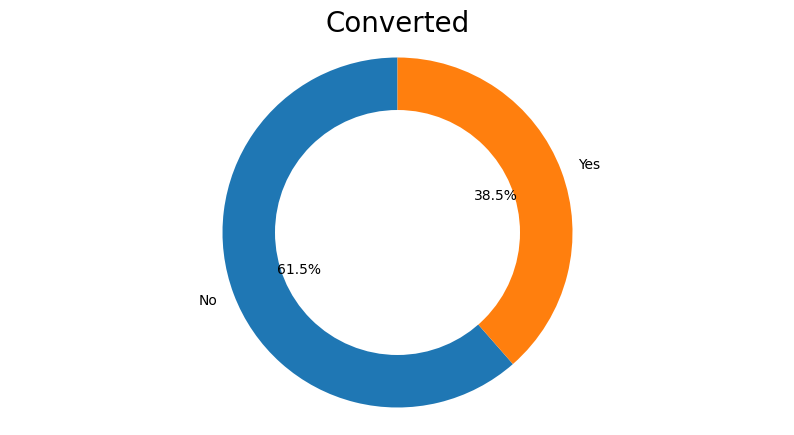

In [37]:
count = df['Converted'].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
ax.pie(count, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90)
ax.set_title('Converted', size=20)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

**Note**: The data is quite balanced

#### 4.2. Categorical Variables Analysis
- Analyse each categorical columns with the target values `Converted`
- Study the conversion rate of each category in each feature

##### Utils

In [38]:
def barplot_catcols(column,width,height):
  """Plot conversion rate"""
  fig, ax  = plt.subplots(figsize=(width,height))
  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,
            order=order(df.fillna('NaN'),column),
            orient='h', palette='viridis',
            seed=2)
  plt.title(f'Conversion Rate by {column.replace("_"," ").title()}', loc='left', size=18)
  return ax

def order(df,x,y=None):
    if y is not None:
        return df.groupby(x)[y].mean().sort_values(ascending=False).index
    else:
        return df.groupby(x)['Converted'].mean().sort_values(ascending=False).index

##### `Lead Origin`

In [39]:
df['Lead Origin'].value_counts()

Lead Origin
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: count, dtype: int64

/tmp/ipykernel_619039/361983025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,


<Axes: title={'left': 'Conversion Rate by Lead Origin'}, xlabel='Converted', ylabel='Lead Origin'>

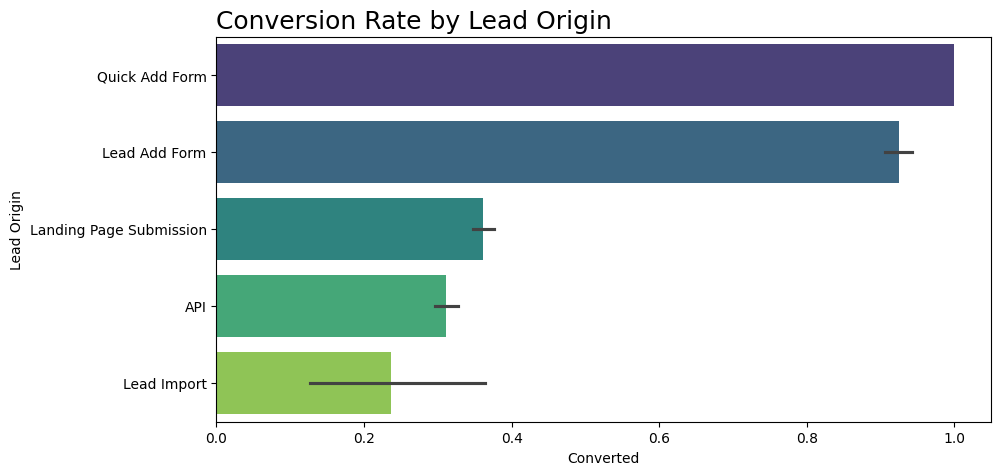

In [40]:
barplot_catcols('Lead Origin',10,5)

##### `Lead Source`

In [41]:
df['Lead Source'].value_counts()

Lead Source
Google               2904
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Live Chat               2
Social Media            2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 1
NC_EDM                  1
Name: count, dtype: int64

**Note**: 
There are multiple small values that can be grouped to the big categories
- "google", "Pay per Click Ads" => "Google"
- "Live Chat" => "Olark Chat"
- "bing" => "Organic Search"
- "welearnblog_Home", "WeLearn", "blog" => "Referal Site"
- The rest to other

In [42]:
# Group similar Lead Sources
df['Lead Source'] = df['Lead Source'].str.replace('|'.join(['google','Pay per Click Ads']),'Google')
df['Lead Source'] = df['Lead Source'].apply(lambda x: "Referral Sites" if 'blog' in str(x) else x)
df['Lead Source'] = df['Lead Source'].str.replace('Live Chat','Olark Chat')
df['Lead Source'] = df['Lead Source'].str.replace('bing','Organic Search')
df['Lead Source'] = df[df['Lead Source'] != 'Other']['Lead Source'].apply(lambda x: "Other" if str(x) not in df['Lead Source'].value_counts()[:8].index else x)

/tmp/ipykernel_619039/361983025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,


<Axes: title={'left': 'Conversion Rate by Lead Source'}, xlabel='Converted', ylabel='Lead Source'>

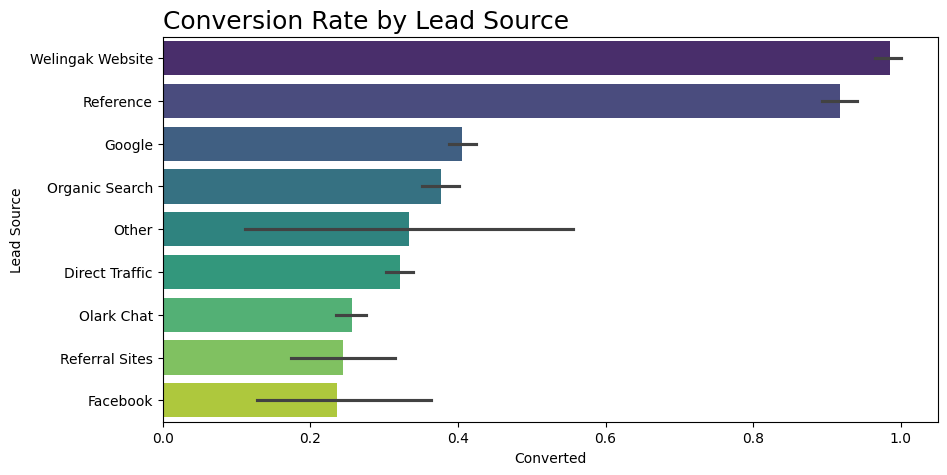

In [43]:
barplot_catcols('Lead Source', 10, 5)

##### `Last Activity` and `Last Notable Activity`

In [44]:
df['Last Activity'].value_counts()

Last Activity
Email Opened                    3540
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Marked Spam                  2
Email Received                     2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: count, dtype: int64

In [45]:
df['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Resubscribed to emails             1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Name: count, dtype: int64

**Note**: Certain values accumulated a lot, and some minor values can be grouped to larger values
- "Email Received" => "SMS Sent"
- "Email Marked Spam", "Email Bounced", "Unsubscribed" => "Not Interested in Email"
- The rest to others

In [46]:
activity = ['Last Activity','Last Notable Activity']
df[activity] = df[activity].replace(['Email Received','SMS Sent'],'SMS/Email Sent')
df[activity] = df[activity].replace(['Email Marked Spam','Email Bounced','Unsubscribed'],'Not Interested in Email')
df[activity] = df[activity].replace(['Had a Phone Conversation', 'View in browser link Clicked', 
                                                       'Visited Booth in Tradeshow', 'Approached upfront',
                                                       'Resubscribed to emails', 'Form Submitted on Website'], 'Others')

/tmp/ipykernel_619039/361983025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,
/tmp/ipykernel_619039/361983025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,


<Axes: title={'left': 'Conversion Rate by Last Notable Activity'}, xlabel='Converted', ylabel='Last Notable Activity'>

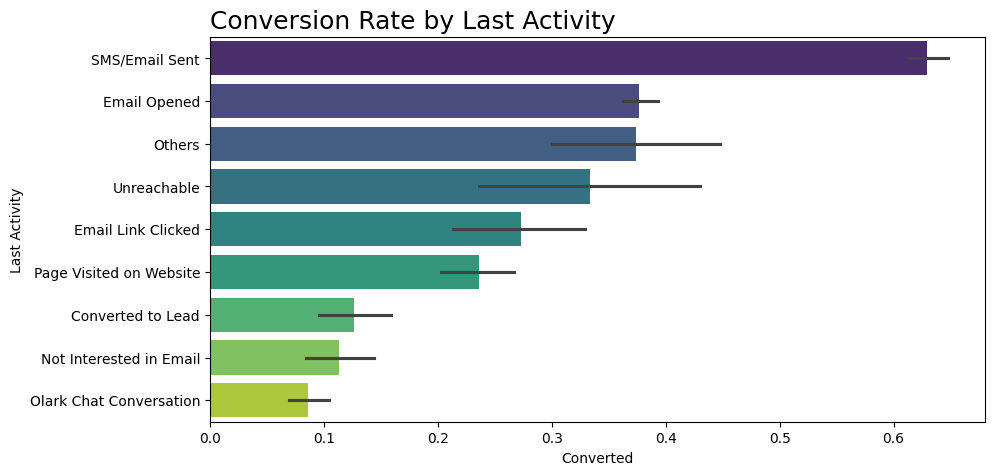

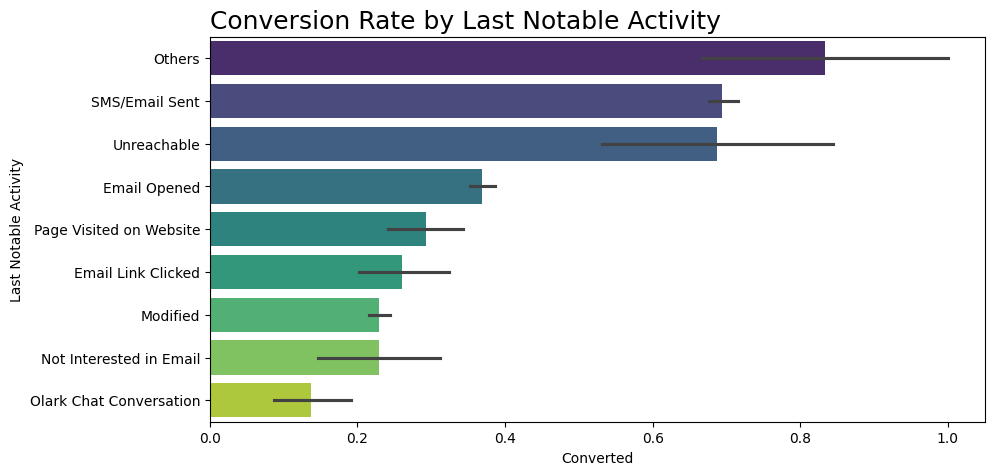

In [47]:
barplot_catcols('Last Activity', 10, 5)
barplot_catcols('Last Notable Activity', 10, 5)

**Note**:
- `Last Notable Activity` seems to provide better information regarding conversion, however, to defined an activity as 'Notable' there should be **another rule** applied as streamlining new data => keeping `Last Activity` is a better choice.

In [48]:
df.drop(columns=['Last Notable Activity'], inplace=True)

In [49]:
cols_to_drop = cols_to_drop + ['Last Notable Activity']

##### `Specialization` and `Occupation`

In [50]:
df['Specialization'].value_counts()

Specialization
Unknown                              3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Media and Advertising                 203
Travel and Tourism                    203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: count, dtype: int64

**Note**: Many categories can be grouped
- "E-COMMERCE", "E-Business" => "E-Commerce"
- "Banking, Investment And Insurance" => "Finance Management"
- "Media and Advertising" => "Marketing Management"

In [51]:
df['Specialization'] = df['Specialization'].str.replace('|'.join(['E-COMMERCE','E-Business']),'E-commerce')
df['Specialization'] = df['Specialization'].str.replace('Banking, Investment And Insurance','Finance Management')
df['Specialization'] = df['Specialization'].str.replace('Media and Advertising','Marketing Management')

/tmp/ipykernel_619039/361983025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,


<Axes: title={'left': 'Conversion Rate by Specialization'}, xlabel='Converted', ylabel='Specialization'>

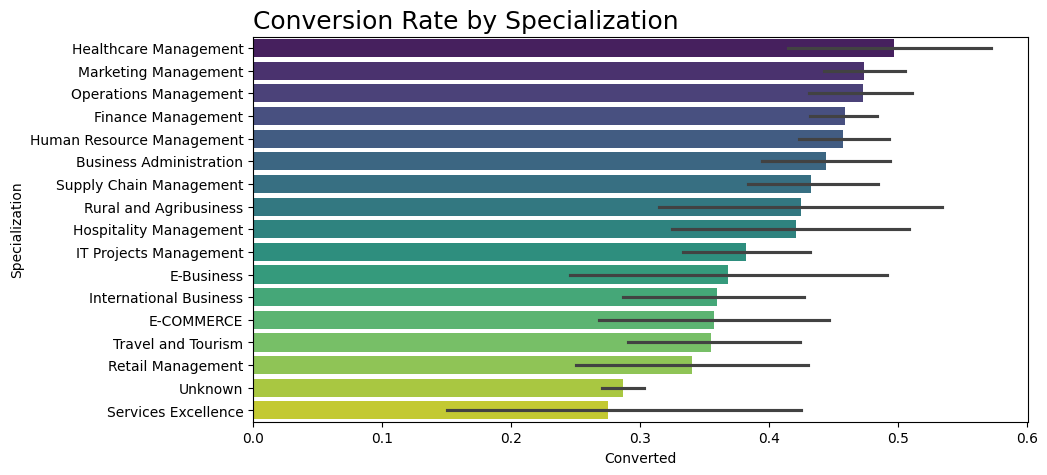

In [52]:
barplot_catcols('Specialization', 10, 5)

In [53]:
df['What is your current occupation'].value_counts()

What is your current occupation
Unemployed              5600
Unknown                 2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: count, dtype: int64

/tmp/ipykernel_619039/361983025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,


<Axes: title={'left': 'Conversion Rate by What Is Your Current Occupation'}, xlabel='Converted', ylabel='What is your current occupation'>

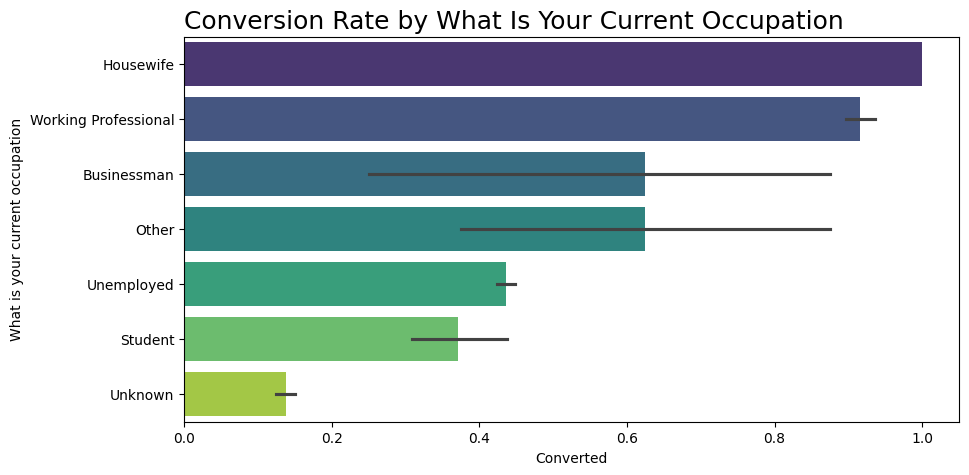

In [54]:
barplot_catcols('What is your current occupation', 10, 5)

##### Binary Categorical Features

In [55]:
binary_cat_cols

['Do Not Email',
 'Do Not Call',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'A free copy of Mastering The Interview']

In [56]:
def pieplot(col):
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    converted = df[col].value_counts().rename_axis('unique_values').to_frame('counts')
    plt.pie(converted.counts, labels = ["No","Yes"],colors = ['red','green'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(col)

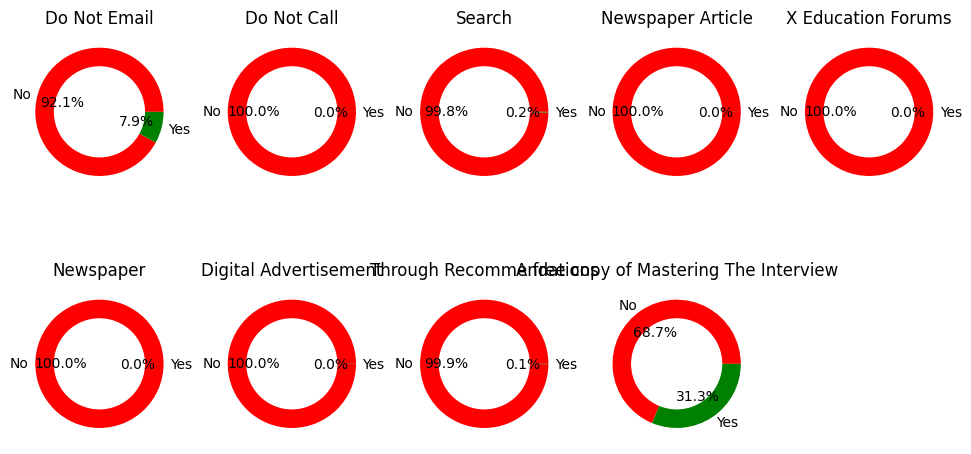

In [57]:
plt.figure(figsize = (12,6))
i=1
for each_col in binary_cat_cols:
    plt.subplot(2,5,i)
    pieplot(each_col)
    i+=1

/tmp/ipykernel_619039/361983025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,


<Axes: title={'left': 'Conversion Rate by A Free Copy Of Mastering The Interview'}, xlabel='Converted', ylabel='A free copy of Mastering The Interview'>

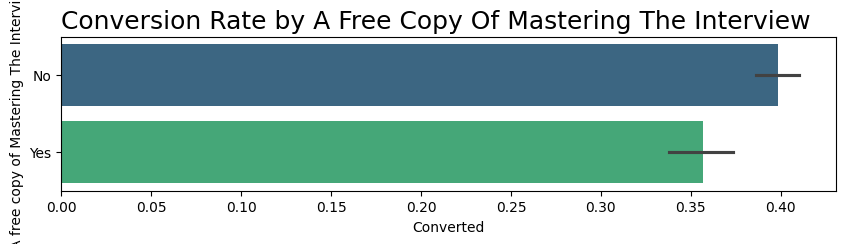

In [58]:
barplot_catcols('A free copy of Mastering The Interview', 10, 2)

/tmp/ipykernel_619039/361983025.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df.fillna('NaN'), x='Converted', y=column,


<Axes: title={'left': 'Conversion Rate by Do Not Email'}, xlabel='Converted', ylabel='Do Not Email'>

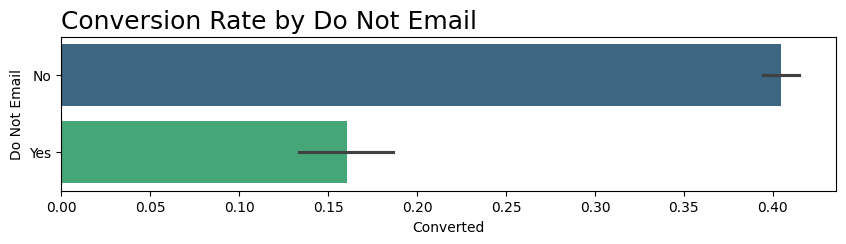

In [59]:
barplot_catcols('Do Not Email', 10, 2)

**Note:**
- Most of the binary categorical cols are heavily skewed => **droppable**
- `A free copy of Mastering The Interview` has different distribution but they share the same conversion rate => not as impactful and reasonably **droppable**

In [60]:
binary_cat_cols.remove('Do Not Email')

In [61]:
df.drop(columns=binary_cat_cols, inplace=True)

In [62]:
cols_to_drop = cols_to_drop + binary_cat_cols

#### 4.3. Numerical Variables

In [63]:
numerical_col

array(['TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit'], dtype=object)

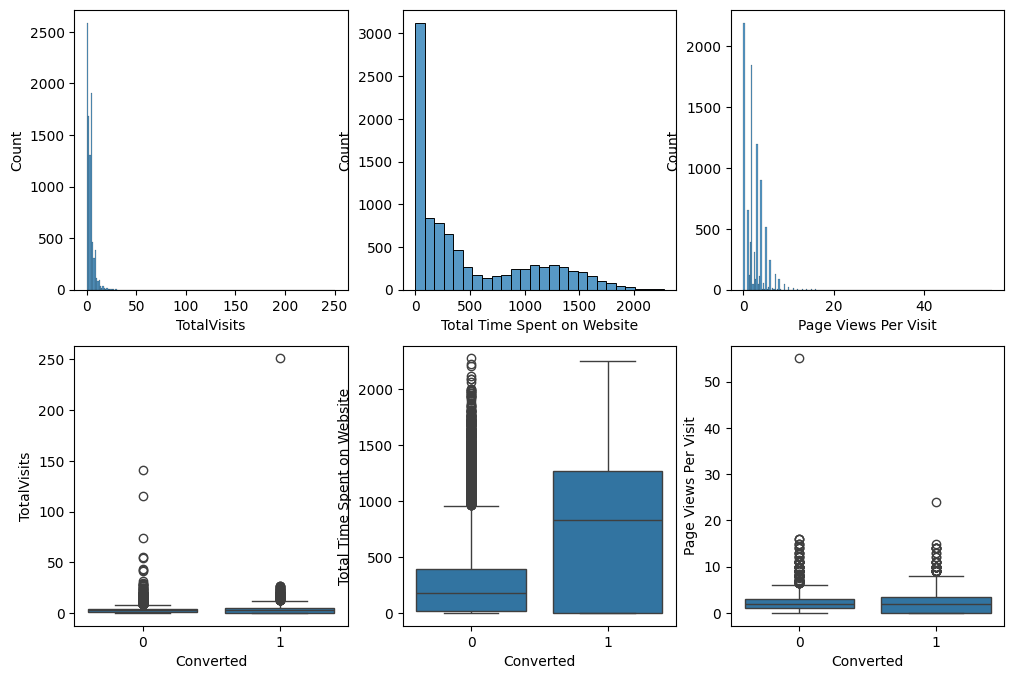

In [64]:
plt.figure(figsize=(12,8))
i = 1
for col in numerical_col:
    plt.subplot(2,3,i)
    sns.histplot(df[col])
    plt.subplot(2,3,3+i)
    sns.boxplot(y=df[col], x = df['Converted'])
    i+=1

**Note**: 
- Leads that convert more spent much more time on the website
- `TotalVisits` and `Page Views per Visit` have outliers which needs to be treated.

## 5. Data Wrangling

### 5.1. Handling outliers
- Addressing outliers in `TotalVisits` and `Page Views Per Visit` is essential for model performance
- **Approach**: Capping at ***95th percentile***

In [65]:
numerical_col

array(['TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit'], dtype=object)

In [66]:
def cap_outliers(df):
  """Replace outliers with the 95th percentile"""
  df[numerical_col[0]] = df[numerical_col[0]].apply(lambda x: df[numerical_col[0]].quantile(.95) if x >= df[numerical_col[0]].quantile(.95) else x)
  df[numerical_col[1]] = df[numerical_col[1]].apply(lambda x: df[numerical_col[1]].quantile(.95) if x >= df[numerical_col[1]].quantile(.95) else x)
  df[numerical_col[2]] = df[numerical_col[2]].apply(lambda x: df[numerical_col[2]].quantile(.95) if x >= df[numerical_col[2]].quantile(.95) else x)
  return df

In [68]:
df = cap_outliers(df)

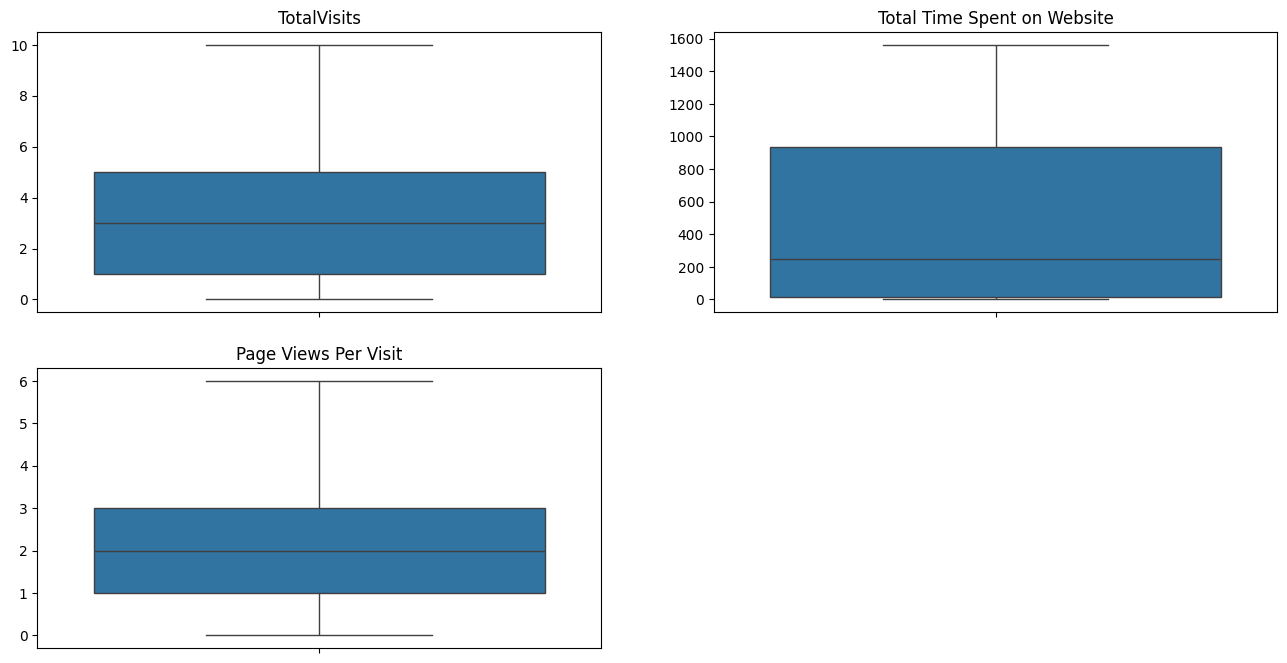

In [69]:
i=1
plt.figure(figsize=[16,8])
for col in numerical_col:
    plt.subplot(2,2,i)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.ylabel('')
    i+=1

### 5.2. Scaling
- Apply ***Standard Scaler*** to make all the values ranged from 0 to 1

## 6. Preprocessing pipeline
- This later uniformedly applied to `train` and `test` dataset as well as future data

##### Initial Pipelines

In [98]:
def drop_cols(df):
    df = df.drop(columns=cols_to_drop)
    return df

drop_cols_transformer = FunctionTransformer(drop_cols)

In [130]:
def feature_engineering(df):
    # Lead Source
    df['Lead Source'] = df['Lead Source'].str.replace('|'.join(['google','Pay per Click Ads']),'Google')
    df['Lead Source'] = df['Lead Source'].apply(lambda x: "Referral Sites" if 'blog' in str(x) else x)
    df['Lead Source'] = df['Lead Source'].str.replace('Live Chat','Olark Chat')
    df['Lead Source'] = df['Lead Source'].str.replace('bing','Organic Search')
    df['Lead Source'] = df[df['Lead Source'] != 'Other']['Lead Source'].apply(lambda x: "Other" if str(x) not in df['Lead Source'].value_counts()[:8].index else x)

    # Last Activity 
    activity = ['Last Activity']
    df[activity] = df[activity].replace(['Email Received','SMS Sent'],'SMS/Email Sent')
    df[activity] = df[activity].replace(['Email Marked Spam','Email Bounced','Unsubscribed'],'Not Interested in Email')
    df[activity] = df[activity].replace(['Had a Phone Conversation', 'View in browser link Clicked', 
                                                        'Visited Booth in Tradeshow', 'Approached upfront',
                                                        'Resubscribed to emails', 'Form Submitted on Website'], 'Others')

    # Specialization
    df['Specialization'] = df['Specialization'].str.replace('|'.join(['E-COMMERCE','E-Business']),'E-commerce')
    df['Specialization'] = df['Specialization'].str.replace('Banking, Investment And Insurance','Finance Management')
    df['Specialization'] = df['Specialization'].str.replace('Media and Advertising','Marketing Management')

    return df

feature_engineering_transformer = FunctionTransformer(feature_engineering)

##### Categorical Pipeline

In [195]:
def binary_encoding(df):
  df[['Do Not Email']] = df[['Do Not Email']].map(lambda x: 0 if x == 'No' else 1)
  return df

def cat_impute(df):
    # replace 'Lead Source' missing values with 'Google'
    df['Lead Source'] = df['Lead Source'].replace(np.nan, 'Google')

    # replace 'Last Activity' missing values with 'Email Opened'
    df['Last Activity'] = df['Last Activity'].replace(np.nan, 'Email Opened')

    # replace missing values with 'Unknown
    unknown_cols = ['Specialization', 'What is your current occupation']
    df[unknown_cols] = df[unknown_cols].fillna('Unknown')

    return df

def cat_processing(df):
    df = binary_encoding(df)
    df = cat_impute(df)
    return df

cat_transformer = FunctionTransformer(cat_processing)


In [196]:
categorical_col = [col for col in categorical_col if col not in cols_to_drop]
#categorical_col.remove('Do Not Email')

In [197]:
categorical_col

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'What is your current occupation',
 'Do Not Email']

In [209]:
cols_to_drop

['Prospect ID',
 'Lead Number',
 'How did you hear about X Education',
 'Lead Profile',
 'Lead Quality',
 'Asymmetrique Profile Score',
 'Asymmetrique Activity Score',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'Tags',
 'I agree to pay the amount through cheque',
 'Get updates on DM Content',
 'Update me on Supply Chain Content',
 'Receive More Updates About Our Courses',
 'Magazine',
 'City',
 'Country',
 'What matters most to you in choosing a course',
 'Last Notable Activity',
 'Do Not Call',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'A free copy of Mastering The Interview']

In [198]:
# One-hot encode the categorical columns
ohe = OneHotEncoder(handle_unknown='ignore')

In [199]:
pipe_cat = make_pipeline(cat_transformer, ohe)

##### Numerical Pipeline

In [200]:
# Impute missing values with KNNImputer
impute_knn = KNNImputer(n_neighbors=5)

# Standardize the data
scaler = StandardScaler()

pipe_num = make_pipeline(impute_knn, scaler)

##### Whole Pipeline

In [201]:
# Column Transformer
columns_transformer = make_column_transformer(
    (pipe_cat, categorical_col),
    (pipe_num, numerical_col),
    remainder='drop'
)

In [202]:
pipeline = make_pipeline(
    drop_cols_transformer, 
    feature_engineering_transformer, 
    columns_transformer
    )

In [203]:
pipeline

,steps,"[('functiontransformer-1', ...), ('functiontransformer-2', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function dro...x79b9ecfb9120>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


##### Test Pipeline

In [204]:
df = pd.read_csv('data/lead_scoring.csv')

In [205]:
X = df.drop('Converted',axis=1)

In [206]:
X_transformed = pipeline.fit_transform(X)